#Libraries Import

In [ ]:
%%capture
!pip install openpyxl==3.0.5
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from matplotlib import pyplot as plt
import seaborn as sns
from google.colab import files

#Get Dataset

In [ ]:
#Uncomment below line if using Colab
files.upload()

df = pd.read_excel('Data_set_v4.5.xlsx')      #Read CSV data file

df = df.drop(["Factor4_Macro_Economic"], axis=1)

#Data Visualization

Text(0.5, 1.0, 'Calls Volume Data')

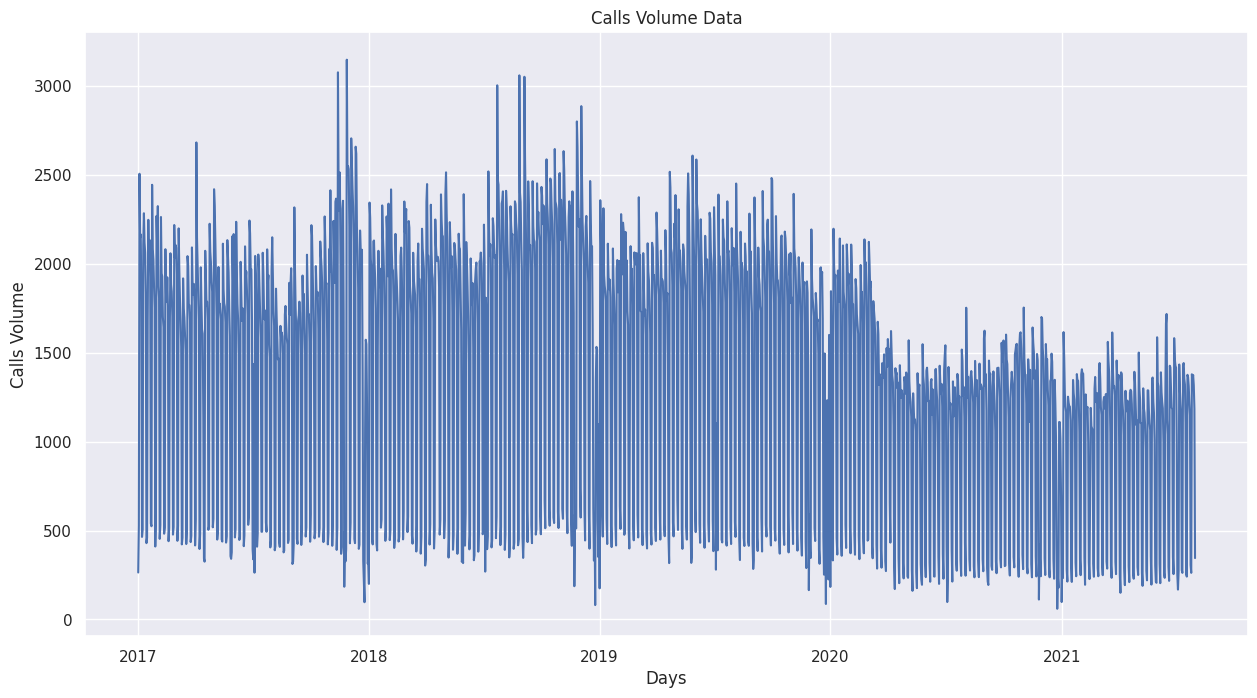

In [ ]:
#Visualization
sns.set_theme()
plt.figure(figsize=(15,8), dpi=100)
plt.plot(df["Date"][:1673], df["No_calls_Offered"][:1673])
plt.xlabel("Days")
plt.ylabel("Calls Volume")
plt.title("Calls Volume Data")

#Data Preprocessing
##Categorical to Numeric Conversion

In [ ]:
#Store the keys for each category
week_day= {'Sunday':0, 'Monday':1,'Tuesday':1,'Wednesday':1,'Thursday':1,'Friday':1,'Saturday':0}
holiday= {'holiday':0, 'no-holiday':1}
df = df.drop(["Factor3_Three-period_moving_average_the_trend","Factor4_seasonality"], axis=1)
weather = {'Cloudy':1, '\tCloudy':1, 'Fair':2, 'Partly Cloudy':1, 'Windy':3,
       'Light Rain':4, 'Mostly Cloudy':1, 'Haze':5, '\tLight Rain':4, 'Mist':5,
       'Rain':4, 'Fog':5, 'Smoke':5, 'Heavy Rain':4, 'Fair ':2, 'Smoke\n':5,
       'Mostly Cloudy ':1, 'Cloudy ':1, 'Partly Cloudy ':1}

#Replace the categorical data with the keys
df['Factor1_Day_of_week']= df['Factor1_Day_of_week'].map(week_day)
df['Factor2_Holidays']= df['Factor2_Holidays'].map(holiday)
df['Factor5_Weather_trends']= df['Factor5_Weather_trends'].map(weather)

#Store the dates in separate variable
Dates = pd.to_datetime(df['Date'])
Dates = Dates[:1673]

#Getting the data
data_cols = list(df)[1:5]

#Getting training data
df_train = df[data_cols].astype(float)

#Feature Scaling

In [ ]:
#Declare the scaler object
scaler = StandardScaler()
#Fit the object to the data
scaler = scaler.fit(df_train)
#Transform the data
df_scaled = pd.DataFrame(scaler.transform(df_train), columns = data_cols)
#Get scaled training data
df_train_scaled=df_scaled[:1673].to_numpy()
#Get features for future prediction
f_factors = df_scaled[1673:].to_numpy()
#Separate Training and future testing data
df = df[:1673]
df_train = df_train[:1673]
df_scaled = df_scaled[:1673]

##Data Preparation for Multivariate Forecasting

In [ ]:
#Declare training and testing arrays
X_train = []
y_train = []
#Value prediction in future
future_value = 1
#Feature window size 
window_size = 14

#For loop over the timeseries data for conversion into windows
for i in range(window_size, len(df_train_scaled) - future_value +1):
    X_train.append(df_train_scaled[i - window_size:i, 0:df_train.shape[1]])
    y_train.append(df_train_scaled[i + future_value - 1:i + future_value, 0])

#Convert to numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

#Long Short Term Memory (LSTM) Model Design

In [ ]:
#Keras sequential Class
model = Sequential()
#Model layers
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dense(y_train.shape[1]))

#Model compilation
model.compile(optimizer='adam', loss='mae')

# Model Training
history = model.fit(X_train, y_train, epochs=500, batch_size=16, verbose=2)

Epoch 1/500
104/104 - 12s - loss: 0.7198 - 12s/epoch - 118ms/step
Epoch 2/500
104/104 - 8s - loss: 0.5366 - 8s/epoch - 80ms/step
Epoch 3/500
104/104 - 8s - loss: 0.3378 - 8s/epoch - 82ms/step
Epoch 4/500
104/104 - 8s - loss: 0.2461 - 8s/epoch - 80ms/step
Epoch 5/500
104/104 - 8s - loss: 0.2216 - 8s/epoch - 80ms/step
Epoch 6/500
104/104 - 8s - loss: 0.2120 - 8s/epoch - 81ms/step
Epoch 7/500
104/104 - 8s - loss: 0.2207 - 8s/epoch - 79ms/step
Epoch 8/500
104/104 - 8s - loss: 0.2057 - 8s/epoch - 78ms/step
Epoch 9/500
104/104 - 8s - loss: 0.2043 - 8s/epoch - 81ms/step
Epoch 10/500
104/104 - 10s - loss: 0.2034 - 10s/epoch - 92ms/step
Epoch 11/500
104/104 - 8s - loss: 0.2045 - 8s/epoch - 79ms/step
Epoch 12/500
104/104 - 8s - loss: 0.1999 - 8s/epoch - 79ms/step
Epoch 13/500
104/104 - 8s - loss: 0.1985 - 8s/epoch - 80ms/step
Epoch 14/500
104/104 - 8s - loss: 0.1914 - 8s/epoch - 79ms/step
Epoch 15/500
104/104 - 8s - loss: 0.1909 - 8s/epoch - 80ms/step
Epoch 16/500
104/104 - 9s - loss: 0.1893 - 9

#Model Evaluation

Text(0, 0.5, 'MAE')

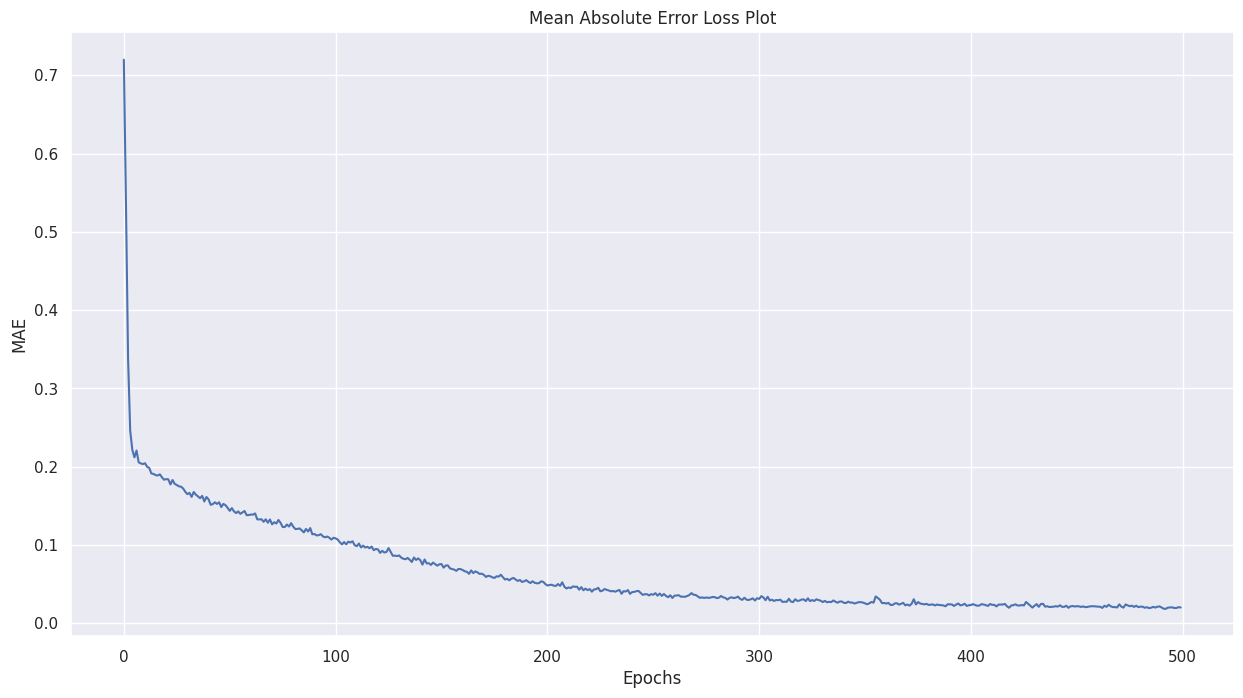

In [ ]:
plt.figure(figsize=(15,8), dpi=100)
plt.plot(history.history['loss'], label='Training loss')
plt.title('Mean Absolute Error Loss Plot')
plt.xlabel("Epochs")
plt.ylabel("MAE")

#Week Evaluation

In [ ]:
#Days to forecast
n_past = 7
#Prediction Dates
predict_period_dates = pd.date_range(list(Dates)[-n_past], periods=n_past, freq='1d').tolist()

#Model Prediction
prediction = model.predict(X_train[-n_past:])
#Inverse Scaling Operation
prediction_copies = np.repeat(prediction, df_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

#Create Dataframe of the Forecasted values    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'No_calls_Offered':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

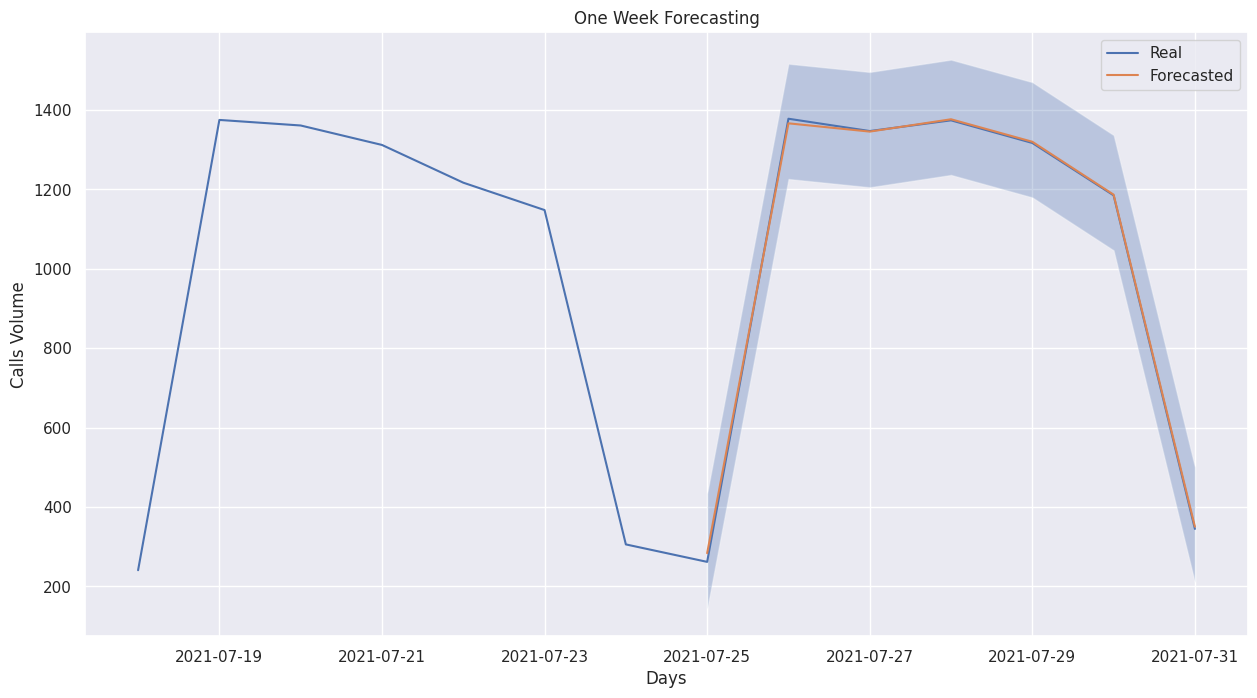

In [ ]:
#Plotting Last week Forecasting Result
a=14
sns.set_theme()
plt.figure(figsize=(15, 8), dpi=100)
plt.fill_between(x=df_forecast['Date'][:a],
                 y1=df_forecast['No_calls_Offered'][:a]+150,
                 y2=df_forecast['No_calls_Offered'][:a]-140,
                 alpha=0.3
                 )
plt.plot(df['Date'][len(df)-a:], df['No_calls_Offered'][len(df)-a:]);
plt.plot(df_forecast['Date'][:a], df_forecast['No_calls_Offered'][:a]);
plt.xlabel("Days")
plt.ylabel("Calls Volume")
plt.title('One Week Forecasting')
plt.grid(True)
plt.legend(["Real", "Forecasted"]);

##Mean Average Percentage Error (MAPE) Score

In [ ]:
Original = df['No_calls_Offered'][len(df)-n_past:].to_numpy()
Forecasted = df_forecast['No_calls_Offered'][:n_past].to_numpy()
MAPE = (1/92)*sum(abs(Original-Forecasted)/abs(Original))*100

print("The Mean Average Percentage Error (MAPE) Score of the model is: ", MAPE)

The Mean Average Percentage Error (MAPE) Score of the model is:  0.12480598845030495


#Month Evaluation

The Mean Average Percentage Error (MAPE) Score of the model is:  2.333377391957227


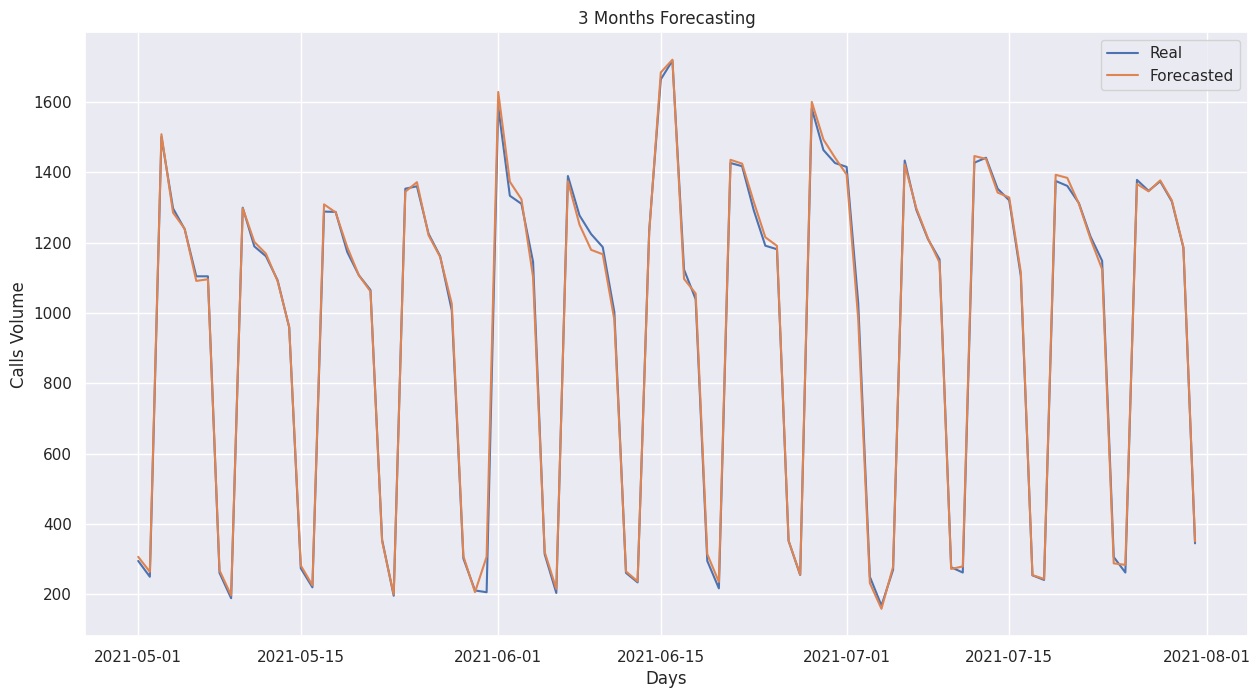

In [ ]:
#Days to forecast
n_past = 92
#Prediction Dates
predict_period_dates = pd.date_range(list(Dates)[-n_past], periods=n_past, freq='1d').tolist()

#Model Prediction
prediction = model.predict(X_train[-n_past:])
#Inverse Scaling Operation
prediction_copies = np.repeat(prediction, df_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

#Create Dataframe of the Forecasted values    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'No_calls_Offered':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

#Plotting Last week Forecasting Result
a=92
sns.set_theme()
plt.figure(figsize=(15, 8), dpi=100)
plt.plot(df['Date'][len(df)-a:], df['No_calls_Offered'][len(df)-a:]);
plt.plot(df_forecast['Date'][:a], df_forecast['No_calls_Offered'][:a]);
plt.xlabel("Days")
plt.ylabel("Calls Volume")
plt.title('3 Months Forecasting')
plt.grid(True)
plt.legend(["Real", "Forecasted"]);

Original = df['No_calls_Offered'][len(df)-n_past:].to_numpy()
Forecasted = df_forecast['No_calls_Offered'][:n_past].to_numpy()
MAPE = (1/92)*sum(abs(Original-Forecasted)/abs(Original))*100

print("The Mean Average Percentage Error (MAPE) Score of the model is: ", MAPE)

#Future Prediction

In [ ]:
#Get last window of features
temp = X_train[0,:,:]
#Variable to store forecasted values
forecast = []

#Loop over future 3 months
for i in range(92):
  #Model Prediction
  pred = model.predict(np.expand_dims(temp, axis=0))
  #Append values
  forecast.append(pred)
  #Delete previous data sample and get new one
  temp = np.delete(temp,0, axis=0)
  temp = np.append(temp, [f_factors[0]], axis=0)
  temp[len(temp)-1,0]=pred

#Rescaling the forecasted values
prediction_temp = np.repeat(np.array(forecast)[:,0], df_train.shape[1], axis=-1)
future_pred = scaler.inverse_transform(prediction_temp)[:,0]

#Week Prediction

In [ ]:
year = [2021, 2021, 2021, 2021, 2021, 2021, 2021]
month = [8, 8, 8, 8, 8, 8, 8]
day = [1, 2, 3, 4, 5, 6, 7]
data = {'year':year, 'month':month, 'day':day}
week_prediction = pd.DataFrame(data = pd.to_datetime( pd.DataFrame(data=data) ), columns = ['Date'])
week_prediction['No_calls_Offered_predicted'] = future_pred[:7]
week_prediction.to_csv("Week_Prediction.csv")

#Month Prediction

In [ ]:
month_prediction = pd.DataFrame(data = ['Aug-2021', 'Sept-2021', 'Oct-2021'], columns=['Date'])
month_prediction['No_calls_Offered_predicted'] = [sum(future_pred[:31]),
sum(future_pred[31:61]),
sum(future_pred[61:92])]
#Save Prediction to CSV
month_prediction.to_csv("Month_Prediction.csv")